# Content and Objective

+ Show application of sinc functions in Shannon's theorem
+ Show sincs and their acf and ccfs when using shifted versions thereof
+ Show reconstruction when sampling a signal according to Shannon's theorem

# Importing and Plotting Options

In [1]:
import numpy as np

from scipy import signal

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Sinc Function for Reconstruction

In [3]:
def sinc( x ):
    '''
    function providing sinc of input value(s)
    
    IN: time values at which to get sinc
    
    OUT: amplitude values of sinc
    '''
    
    out = np.zeros_like( x )
    
    for ind_x, val_x in enumerate( x ):
        
        if val_x != 0:
            out[ ind_x ] = np.sin( np.pi * val_x ) / (np.pi * val_x )
        else:
            out[ ind_x ] = 1
    
    return out

# Show that Sinc Functions are orthogonal

In [24]:
# "internal" sample time used for getting "analog" signals
t_s = 0.01   

# parameters of sinc function
T = 1
W = 1 / ( 2 * T )

# set time resp. pulse interval and related parameters
t_min = -50.0
t_max = 50.0

t = np.arange( t_min, t_max + t_s, t_s )

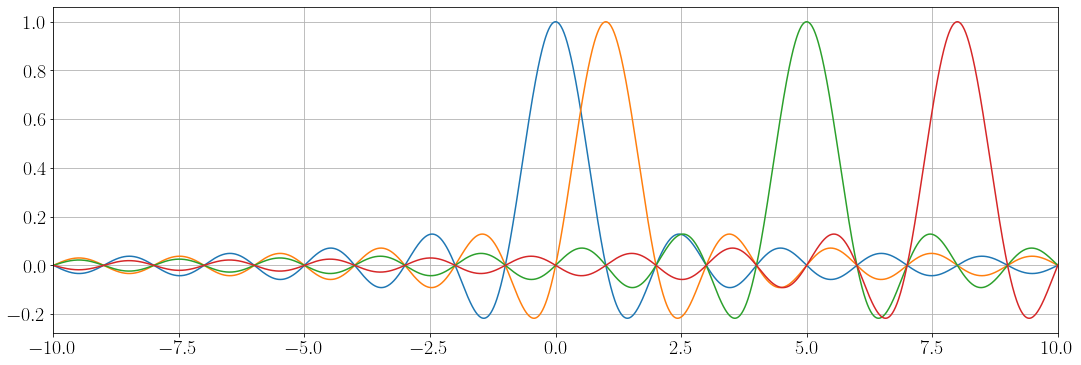

In [25]:
# compare sincs for different shifts 
T1 = 0
T2 = [ 1, 5, 8 ] 

# sinc function with shift T1 being used for comparison
sinc_1 = sinc( 2*W*t - T1 ) 

plt.plot( t, sinc_1 )
plt.xlim( (-10, 10) )
plt.grid( True )

for t2 in T2:
    plt.plot( t, sinc( 2*W*t - t2 ) )


(-10.0, 10.0)

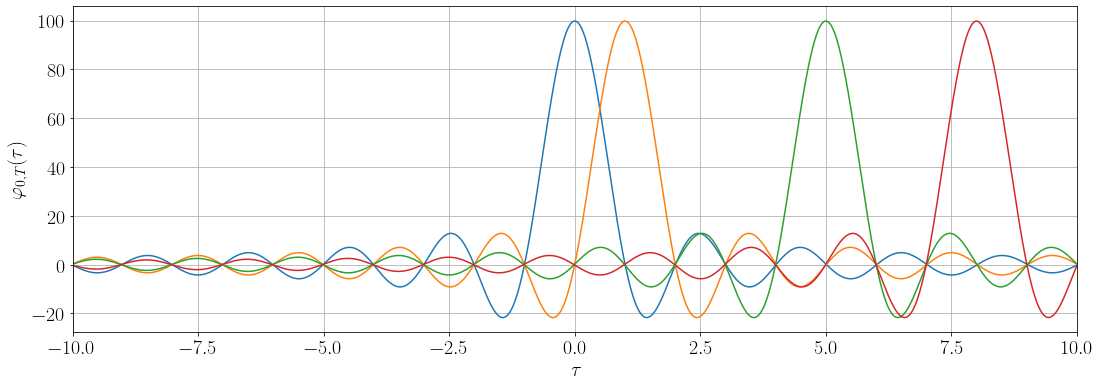

In [26]:
# vectors of times used for correlation
# NOTE: result of correlation possessing longer duration!
t_corr = np.arange( 2*t_min, 2*t_max+t_s, t_s)

plt.plot( t_corr, np.correlate( sinc_1, sinc_1, 'full' ) )
plt.xlim( (-20, 20) )
plt.grid( True )

for t2 in T2:
    plt.plot( t_corr, np.correlate( sinc( t - t2 ), sinc_1  , 'full' ) )
             
plt.ylabel( '$\\varphi_{0, T}(\\tau)$' )    
plt.xlabel('$\\tau$')
plt.xlim( (-10, 10) )

### Questions:

- Why are the "peaks" on the left hand side of the y-axis?
- Why are we not observing ccfs equal to zero as derived in the lecture?

# Show Reconstruction Formula

In [27]:
# "internal" sample time used for getting "analog signals
t_s = 0.01      

# sample time for Shannon-sampling
t_sample = .25   

In [28]:
# set time resp. pulse interval and related parameters
t_min = -0.0
t_max = 10.0

t = np.arange(t_min, t_max+t_s, t_s)

delta_t_sample = t_sample/4
t_sampled = np.arange(t_min + delta_t_sample, t_max + delta_t_sample + t_sample, t_sample )

In [29]:
# original signal and sampled version
# choosing the signal: first one being a sine function, second one being a random function, third... (up to you)

if 1:
    
    # osc. frequency, signal and sampled version of the signal
    f0 = 1 

    x = np.sin( 2 * np.pi * f0 * t )
    x_sampled = np.sin( 2 * np.pi * f0 * t_sampled )

if 1:
    # get random function by randomly cascading 4 functions 
    # get sum of two sine functions
    N_max = 15
    N = 3 + np.random.randint( N_max )

    coeffs = np.random.rand( N ) * ( -1 )**np.random.randint( 2, size=N )
    poly = np.polynomial.polynomial.Polynomial( coeffs )

    functions = [ np.sin, np.arcsin, np.sqrt, np.log, np.exp, np.i0, np.sinh, np.arcsinh, np.sinc, poly]

    fct = np.random.choice( functions, 4)
    x = t
    for f in fct:
        x = f( x )
        x[ np.isnan( x ) ] = 0
        x[ np.isinf( x ) ] = 0

    x_sampled = t_sampled

    for f in fct:
        x_sampled = f( x_sampled )
        x_sampled[ np.isnan( x_sampled ) ] = 0
        x_sampled[ np.isinf( x_sampled ) ] = 0
    

In [30]:
# reconstruction by directly following the sampling theorem
x_recon = 0 * t

# loop along sampling points and synthesize signal
for k in np.arange( 0, len( t_sampled ) ):
    
    # getting arg of sinc function and constructing sinc
    argument = 1 / t_sample * ( t - k * t_sample )
    recon_sum_part = sinc( argument )

    # summing up all sinc kernels with according pre-factors
    x_recon += x_sampled[ k ] * recon_sum_part
        
    
    

### plotting

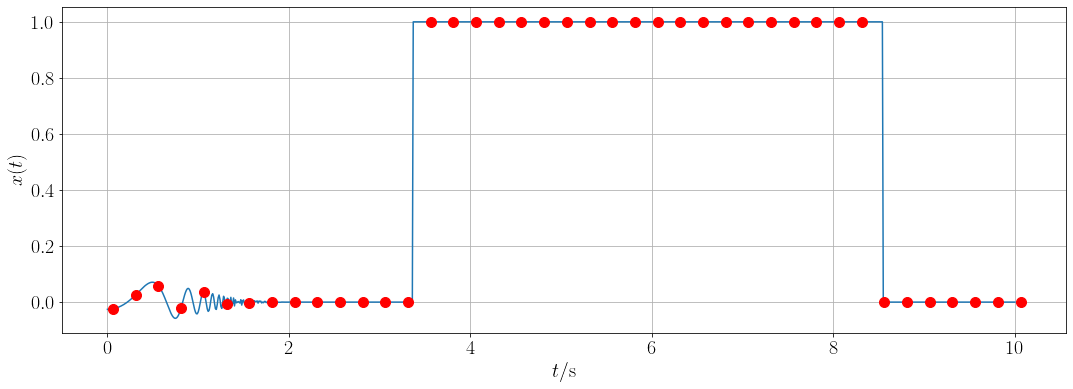

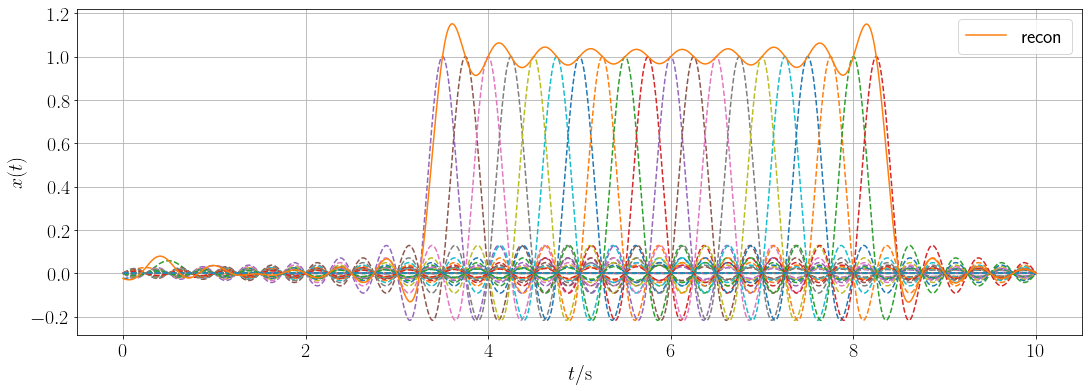

In [31]:
plt.figure(121)
plt.plot( t, x )
plt.plot( t_sampled, x_sampled, 'ro', markersize=10)

plt.grid(True); plt.xlabel('$t/\mathrm{s}$');  plt.ylabel('$x(t)$')
    

plt.figure(122)

for k in np.arange( 0, len( t_sampled ) ):
    
   # getting arg of sinc function and constructing sinc
    argument = 1 / t_sample * ( t - k * t_sample )
    recon_sum_part = sinc( argument ) 
    
    plt.plot(t, x_sampled[k] * recon_sum_part,'--')

plt.plot( t, x_recon, label='recon' )

plt.grid(True); 
plt.xlabel('$t/\mathrm{s}$');  
plt.ylabel('$x(t)$')
plt.legend(loc='upper right')
        
    
    

# Show Images by Applying Oversampling

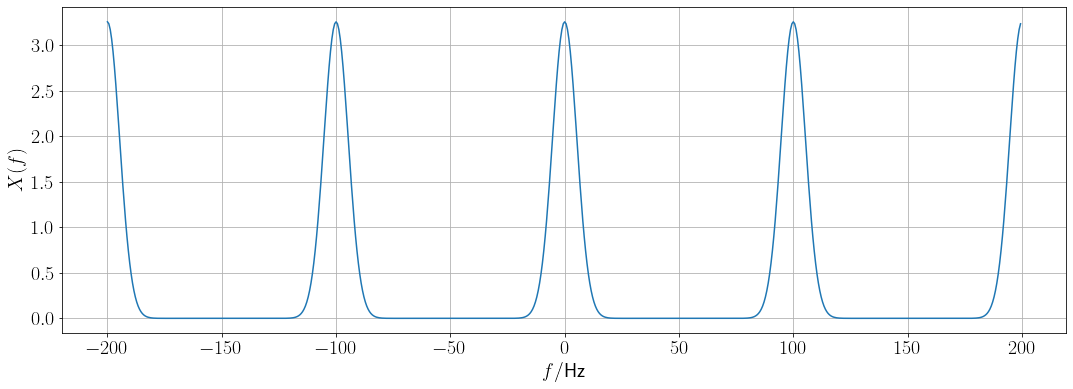

In [32]:
# sampled signal equalling normalized gaussian
x_samp = ( signal.gausspulse( t_sampled - 3, 1, retenv=1 ) )[1] 
x_samp = x_samp * np.sqrt( 1 / sum( x_samp**2 ) )

# define upsampling factor and do upsampling
N_up = 4
x_up = np.zeros( len( x_sampled ) * N_up )
x_up[ :: N_up ] = x_samp


#######
# Q: what do you think why this line is important?
#######
x_up = np.hstack( [ x_up, np.zeros( 3*len(x_up) ) ] )

X = np.fft.fft( x_up )
f = np.arange( -N_up/(2*t_s), N_up/(2*t_s) , N_up/(t_s*len(x_up)) )

plt.plot( f, np.abs( X ) )
plt.grid( True )
plt.xlabel('$f/$Hz')
plt.ylabel('$X(f)$');